In [4]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

In [30]:
test_folder =  'test_non_aug'
image_folder = "galaxies/317018/317018"
model_path = 'Models'

In [29]:
#folder to check (there are 20)
galaxies_batch_to_check = "galaxies/317018/Subfolder_8"

#visualize

In [10]:
import matplotlib.pyplot as plt

def visualize(y_true, y_pred):
  # Sample lists of truth values and corresponding float values
  truth_values = y_true
  float_values = y_pred

  # Separate the data points based on truth values
  true_points = [(x, y) for x, y in zip(truth_values, float_values) if x == 1]
  false_points = [(x, y) for x, y in zip(truth_values, float_values) if x == 0]

  # Unzip the points to separate x and y values for plotting
  true_x, true_y = zip(*true_points)
  false_x, false_y = zip(*false_points)

  # Plot the points with different colors based on truth values
  plt.scatter(false_x, false_y, color='red', label='False (0)')
  plt.scatter(true_x, true_y, color='green', label='True (1)')

  # Plot the line y = 0.5
  plt.axhline(y=0.5, color='blue', linestyle='--', label='y = 0.5')

  # Add labels and legend
  plt.xlabel('Truth Value')
  plt.ylabel('Float Value')
  plt.legend()

  # Show the plot
  plt.show()


#test on the testing dataset (don't run)

In [5]:
# Path to the folder where the saved model is located
model_folder_path = model_path + "/models"

# Load the saved model
model = load_model(model_folder_path)

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Load the test data
test_data_dir = test_folder # Replace with the path to your test data directory
test_datagen = ImageDataGenerator(rescale=1.0/255.0)
ds_test = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=[224, 224],
    batch_size=4,
    class_mode='binary',
    shuffle=False # Convert images to grayscale
)

# Get the true labels
y_true = ds_test.classes

# Make predictions
y_pred = model.predict(ds_test)
#y_pred = np.round(y_pred).flatten().astype(int)

Found 117 images belonging to 2 classes.
 1/30 [>.............................] - ETA: 1:11

KeyboardInterrupt: ignored

In [14]:
y = [float(i+0.1502) for i in y_pred]
y_flat = [int(i) for i in np.round(y).flatten().astype(int)]

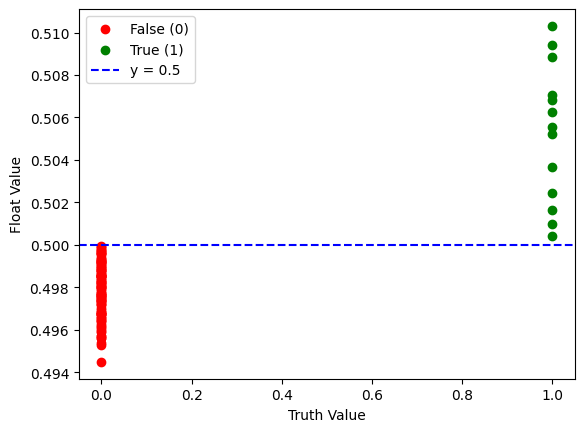

In [15]:
visualize(y_flat, y)

TP TN FP FN
12 99 1 5
Accuracy 0.9487179487179487
F1 0.8000000000000002
Recall 0.7058823529411765
Precision 0.9230769230769231


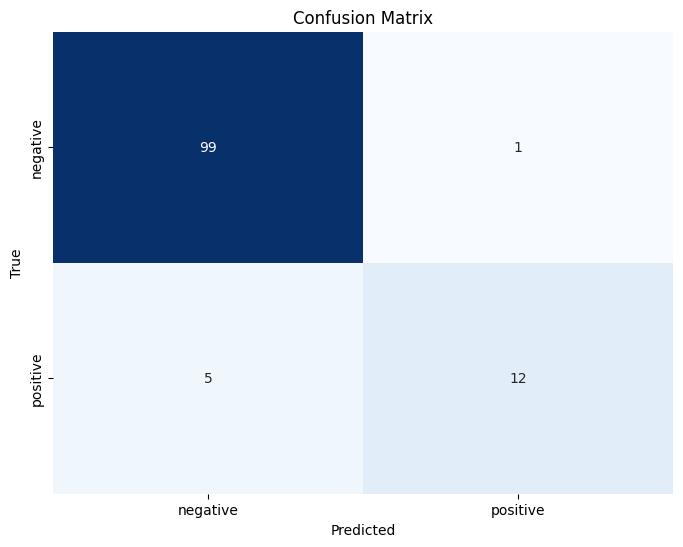

In [16]:
# Compute the confusion matrix
class_labels = {0:'negative', 1:'positive'}
cm = confusion_matrix(y_true, y_flat)
TP = cm[1][1]
FP = cm[0][1]
TN = cm[0][0]
FN = cm[1][0]
print("TP TN FP FN")
print(TP, TN, FP, FN)

precision =  float(TP/(TP + FP))
recall = TP/(TP + FN)

f1 = 2*(precision*recall)/(precision + recall)

print("Accuracy", (TP+TN)/(TP+FP+TN+FN))
print("F1", f1)
print("Recall", recall)
print("Precision", precision)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False,
            xticklabels=class_labels.values(), yticklabels=class_labels.values())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

#check all galaxies

## check all galaxies

In [17]:
import numpy as np
from keras.preprocessing import image
from keras.applications import VGG16  # Replace with your desired pre-trained model
from keras.applications.vgg16 import preprocess_input, decode_predictions  # Adjust imports based on the model
from PIL import Image
import os
from tqdm import tqdm

In [19]:
import os
galaxies_path = image_folder

In [20]:
from tqdm import tqdm
def get_paths(path):
  p = os.scandir(path)
  image_paths = []
  max = 400000
  i = 0
  with tqdm(total=max) as pbar:
      for entry in p:
          if i == max:
            break
          image_paths.append(entry.path)
          pbar.update(1)
          i += 1
  return image_paths

In [21]:
import os
import numpy as np
import concurrent.futures
from keras.preprocessing import image
import tensorflow as tf

def predict_folder(image_paths):
  # List of file paths
  file_paths = get_paths(image_paths)
  print(file_paths)
  # Define batch size and number of workers
  batch_size = 4
  num_workers = 4

  # Load and preprocess data
  def preprocess_image(image_path):
        img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = tf.keras.applications.mobilenet_v2.preprocess_input(img)  # Preprocess based on your model's requirements
        return img

  # Create batches of file paths
  def create_batches(data, batch_size):
      for i in range(0, len(data), batch_size):
          yield data[i:i + batch_size]

  # Predict function for a single batch
  def predict_batch(batch):
      try:
        batch_images = [preprocess_image(image_path) for image_path in batch]
        batch_images = np.vstack(batch_images)  # Stack images in batch
        predictions = model.predict(batch_images)
        return predictions
      except:
        print("Failed for ", batch)
        return [[None]]

  # Split file_paths into batches
  batches = list(create_batches(file_paths, batch_size))

  # Parallel processing using ThreadPoolExecutor
  with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
      all_predictions = list(executor.map(predict_batch, batches))
  return all_predictions

In [22]:
all_predictions = predict_folder(galaxies_batch_to_check)

  0%|          | 800/400000 [00:00<00:06, 60659.54it/s]


['/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358616150131.jpeg', '/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358616150142.jpeg', '/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358616215609.jpeg', '/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358616215706.jpeg', '/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358616281332.jpeg', '/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358616346722.jpeg', '/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358616412216.jpeg', '/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358616412272.jpeg', '/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358616412296.jpeg', '/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358616412300.jpeg', '/content/drive/MyDrive/Degree/Jobs/SIG

In [23]:
all_predictions_1 = [[x] if x is None else x for x in all_predictions]

In [24]:
# Flatten the nested list of NumPy arrays
flattened_list = [item for sublist in all_predictions_1 for item in sublist]
# Convert the flattened list back to NumPy arrays
flattened_numpy_arrays = [np.array(item) for item in flattened_list]
len(flattened_numpy_arrays)

800

In [25]:
image_path = galaxies_batch_to_check

  0%|          | 800/400000 [00:00<00:06, 66173.18it/s]

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358616150131.jpeg', 0.4963134433746338)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358616150142.jpeg', 0.4968542065143585)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358616215609.jpeg', 0.4988992418766022)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358616215706.jpeg', 0.49927329082489014)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358616281332.jpeg', 0.4961290862083435)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358616346722.jpeg', 0.5011663045406342)


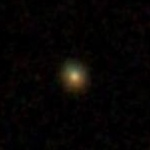

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358616412216.jpeg', 0.49573733468055725)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358616412272.jpeg', 0.4949183668613434)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358616412296.jpeg', 0.4976547564983368)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358616412300.jpeg', 0.4961838628768921)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358616477716.jpeg', 0.4910762514591217)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358616543266.jpeg', 0.49332164783477783)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358616543377.jpeg', 0.49676062722206116)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358616608906.jpeg', 0.5003771688461304)


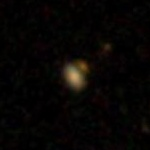

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358616739965.jpeg', 0.5001072194099426)


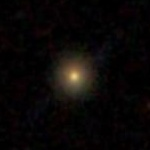

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358616739967.jpeg', 0.5015416945934296)


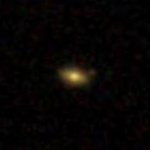

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358616936604.jpeg', 0.4960210527896881)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358617002066.jpeg', 0.49988799352645874)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358617002140.jpeg', 0.4978492166519165)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358617067688.jpeg', 0.5005177464008331)


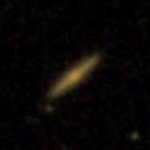

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358617067696.jpeg', 0.4946967567920685)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358617067708.jpeg', 0.4989938344478607)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358617133091.jpeg', 0.4973043109893799)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358617133125.jpeg', 0.4956103171825409)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358617133139.jpeg', 0.49828430075645447)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358617133150.jpeg', 0.49501731057167053)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358617133178.jpeg', 0.5020783748149872)


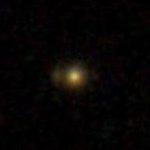

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358617133194.jpeg', 0.49218835492134094)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358617198699.jpeg', 0.4996073450565338)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358617264263.jpeg', 0.49491210837364197)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358617329762.jpeg', 0.5004517640590668)


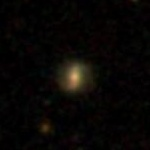

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358617329799.jpeg', 0.4996345247745514)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358617329818.jpeg', 0.4983522500514984)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358617329837.jpeg', 0.5007195677280426)


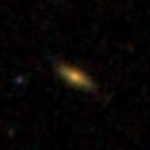

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358617460937.jpeg', 0.49843504090309143)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358617461046.jpeg', 0.49633820910453796)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358617788583.jpeg', 0.4972763862133026)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358617788593.jpeg', 0.49840932149887085)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358617854052.jpeg', 0.49877404232025147)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358617919521.jpeg', 0.49282213110923767)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358617919572.jpeg', 0.4972422625541687)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358617985164.jpeg', 0.4979996587753296)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/S

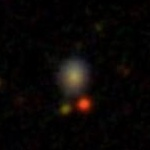

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358618706049.jpeg', 0.49540283341407776)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358618837079.jpeg', 0.49775343198776245)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358618837094.jpeg', 0.49917616505622864)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358619033742.jpeg', 0.4982824828147888)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358619033756.jpeg', 0.4938943292617798)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358619033816.jpeg', 0.49849509258270264)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358619099152.jpeg', 0.49517565031051636)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358619230308.jpeg', 0.49906956214904785)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/

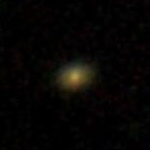

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358620082187.jpeg', 0.4927998389720917)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358620082274.jpeg', 0.49776356477737427)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358620147730.jpeg', 0.495062163066864)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358620147788.jpeg', 0.4993588830947876)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358620213315.jpeg', 0.4997607078075409)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358620344362.jpeg', 0.49785005111694336)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358620344377.jpeg', 0.49708451886177063)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661358620344386.jpeg', 0.49708177704811096)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Sub

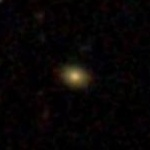

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360229515276.jpeg', 0.49927177090644836)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360229515370.jpeg', 0.4966248478412628)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360229777577.jpeg', 0.49993862767219543)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360229843315.jpeg', 0.4956245626926422)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360229974255.jpeg', 0.49513136405944824)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360230170725.jpeg', 0.49848704595565796)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360230301838.jpeg', 0.49830546040534973)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360230891642.jpeg', 0.49844568033218384)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/

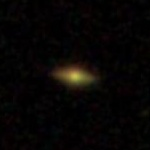

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360758194324.jpeg', 0.49689116139411926)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360758194333.jpeg', 0.4989188220024109)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360758259809.jpeg', 0.4945450629711151)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360758259842.jpeg', 0.49721329469680786)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360758259872.jpeg', 0.49611835737228394)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360758325303.jpeg', 0.4967784788131714)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360758456411.jpeg', 0.4937807526111603)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360758456458.jpeg', 0.49495359320640564)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Su

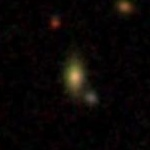

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360760356932.jpeg', 0.49716710109710693)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360760422464.jpeg', 0.49744685549736023)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360760619095.jpeg', 0.4991197790622711)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360760684632.jpeg', 0.49883385558128357)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360760684739.jpeg', 0.49912261028289795)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360760815785.jpeg', 0.49603780169487)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360760946765.jpeg', 0.49653129835128784)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360760946807.jpeg', 0.4995630886077881)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Sub

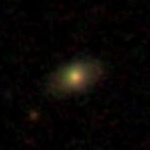

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360761536647.jpeg', 0.49867792983055115)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360761667669.jpeg', 0.4964316691875458)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360761733210.jpeg', 0.5000380780220032)


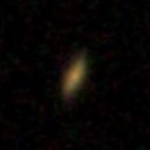

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360761798721.jpeg', 0.4988365079879761)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360761864290.jpeg', 0.4984816219329834)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360761864342.jpeg', 0.4950551297187805)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360761864349.jpeg', 0.4989454056739807)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360762192090.jpeg', 0.5020280982971191)


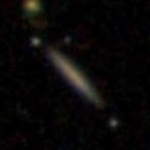

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360762257515.jpeg', 0.49668382663726807)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360762322953.jpeg', 0.500375142288208)


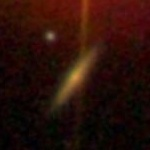

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360762323091.jpeg', 0.4997379090309143)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360762454084.jpeg', 0.4989361967563629)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360762454103.jpeg', 0.49895810146331787)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360762519683.jpeg', 0.5001382138252258)


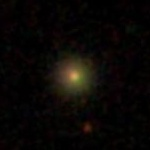

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360762585190.jpeg', 0.4999985601425171)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360762650714.jpeg', 0.49911876578330994)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360762650720.jpeg', 0.49921517629623413)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360762716243.jpeg', 0.4968578423976898)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360762781869.jpeg', 0.4955201651573181)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360762847344.jpeg', 0.4982420410633087)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360762978484.jpeg', 0.4984572138309479)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360763175044.jpeg', 0.49943070669174194)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Sub

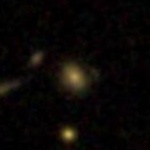

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360763633742.jpeg', 0.49500398893356323)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360763633770.jpeg', 0.49607612748146057)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360763699352.jpeg', 0.4999925400733948)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360763764852.jpeg', 0.4944830443382263)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360763764889.jpeg', 0.49580054540634155)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360763830333.jpeg', 0.4978991355419159)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360764026954.jpeg', 0.5005197431564331)


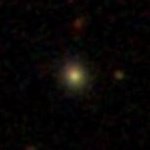

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360764026982.jpeg', 0.4963841940879822)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360764223678.jpeg', 0.49755557436943054)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360764289228.jpeg', 0.4986404683113098)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360764354798.jpeg', 0.49605827589035034)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360764485782.jpeg', 0.4995082821369171)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360764551289.jpeg', 0.49592869539260864)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360764551291.jpeg', 0.4978857542991638)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360764551295.jpeg', 0.49810733456611633)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Su

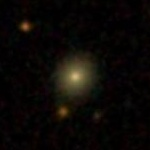

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360765665419.jpeg', 0.5001636650085449)


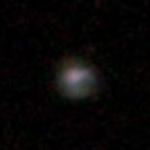

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360765730944.jpeg', 0.49968283433914185)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360765796461.jpeg', 0.5009207036018372)


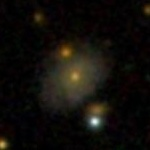

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360765796507.jpeg', 0.4989280607223511)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360765796557.jpeg', 0.4958641435623169)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360765796560.jpeg', 0.4990079905509949)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360765862128.jpeg', 0.4917723443031311)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360765862130.jpeg', 0.49282025356292725)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360765927652.jpeg', 0.5025050248622894)


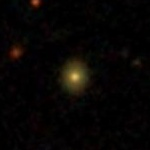

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360765993101.jpeg', 0.5015275384902954)


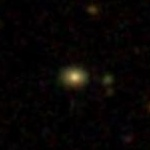

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360765993131.jpeg', 0.49933864731788635)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360765993141.jpeg', 0.49854709763526917)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360765993200.jpeg', 0.49759288687705994)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360766058695.jpeg', 0.499322017621994)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360766124085.jpeg', 0.49985261816978455)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360766124129.jpeg', 0.5000157858848572)


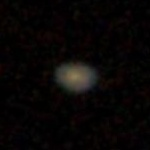

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360766124160.jpeg', 0.5005791093826294)


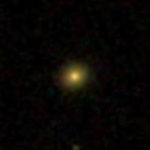

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360766189642.jpeg', 0.49434002299308777)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360766189768.jpeg', 0.49692847390174866)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360766451850.jpeg', 0.5009513999938965)


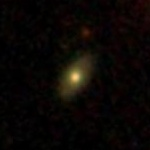

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360766451903.jpeg', 0.4996018316268921)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360766713998.jpeg', 0.4963722433567047)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360767041614.jpeg', 0.4948514308452606)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360767107167.jpeg', 0.4973260964870453)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360767107230.jpeg', 0.49807052869796753)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360767238348.jpeg', 0.49862318296432495)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360767959217.jpeg', 0.4999414290904999)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360768221353.jpeg', 0.49848296303749084)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Sub

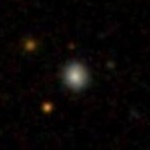

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360768549063.jpeg', 0.5005083884716034)


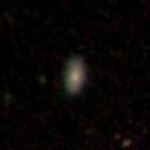

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360768614637.jpeg', 0.494228115272522)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360768680089.jpeg', 0.4999886061668396)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360768811137.jpeg', 0.49753667969703674)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360768811145.jpeg', 0.5006474759101868)


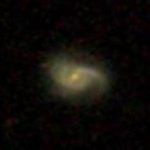

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360768942417.jpeg', 0.492846986246109)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360769007833.jpeg', 0.4984443690299988)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360769073347.jpeg', 0.4993003215312958)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360769138813.jpeg', 0.4991227294921875)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360769138857.jpeg', 0.49942468662261963)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360769269991.jpeg', 0.49703987498283386)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360769270006.jpeg', 0.4981231297969818)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360769335465.jpeg', 0.495672127199173)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfol

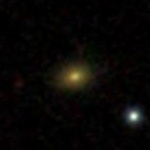

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360769400949.jpeg', 0.49914585609436035)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360769597595.jpeg', 0.5010279025554657)


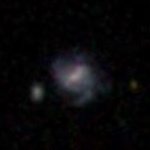

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360769597641.jpeg', 0.5005609299659729)


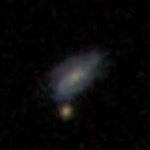

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360769597652.jpeg', 0.4955060984611511)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360769663005.jpeg', 0.49680589694976807)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360769925342.jpeg', 0.4993933345794678)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360770056305.jpeg', 0.496680131149292)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360770318552.jpeg', 0.49530302543640137)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360770449602.jpeg', 0.5018027331352234)


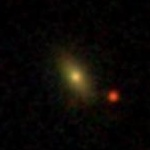

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360770449610.jpeg', 0.49810313243865967)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360770515266.jpeg', 0.4955511893749237)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360770580658.jpeg', 0.49736519713401794)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360770842785.jpeg', 0.5002747084617615)


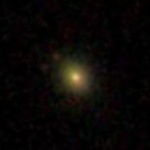

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360771039416.jpeg', 0.4976559783935547)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360771039430.jpeg', 0.4976794328212738)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360771039446.jpeg', 0.4977152254104614)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360771039459.jpeg', 0.4973408486366272)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661360771039539.jpeg', 0.49876271743774414)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361294082159.jpeg', 0.49823685545921326)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361294082177.jpeg', 0.4993378724575043)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361294147632.jpeg', 0.49308689494132996)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Sub

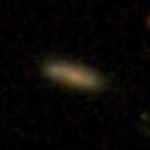

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361294606368.jpeg', 0.49982597489356995)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361294672057.jpeg', 0.5002542044639587)


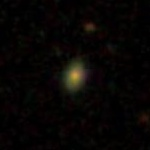

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361294934107.jpeg', 0.49923809428215027)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361294934119.jpeg', 0.4970254506587982)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361294934140.jpeg', 0.5007590856075287)


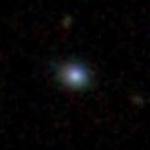

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361294999618.jpeg', 0.4994937982082367)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361294999629.jpeg', 0.49866383333206177)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361294999679.jpeg', 0.4983976091861725)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361295065194.jpeg', 0.4927445556640625)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361295065209.jpeg', 0.4978969599723816)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361295130694.jpeg', 0.4972572531223297)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361295130698.jpeg', 0.4976665582180023)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361295130708.jpeg', 0.49825452823638916)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subf

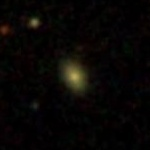

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361296638042.jpeg', 0.4941570665359497)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361296638070.jpeg', 0.4952072407722473)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361296638072.jpeg', 0.49562933106422424)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361296638083.jpeg', 0.49634524245262146)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361296638095.jpeg', 0.4950011875152588)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361296703613.jpeg', 0.4943581130027771)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361296769032.jpeg', 0.494459113073349)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361296769252.jpeg', 0.49679186005592346)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subf

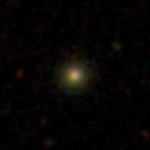

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361297686637.jpeg', 0.4993455912590027)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361297686646.jpeg', 0.49938463230133057)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361297817902.jpeg', 0.49601777453422546)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361297948751.jpeg', 0.49854927320480347)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361297948771.jpeg', 0.49872901101112366)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361298014230.jpeg', 0.4979441668510437)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361298014323.jpeg', 0.49895237941741943)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361298276521.jpeg', 0.4986223484992981)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/S

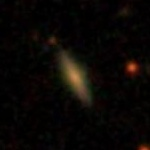

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361298800869.jpeg', 0.4992305244922638)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361298866246.jpeg', 0.4978523458957672)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361298931786.jpeg', 0.49978356618881226)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361298931813.jpeg', 0.5009709503173828)


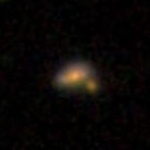

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361298997366.jpeg', 0.49987923164367676)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361299128487.jpeg', 0.4987428988933563)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361299193882.jpeg', 0.4976288284778595)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361299193954.jpeg', 0.4976200963973999)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361299193987.jpeg', 0.4969489182949066)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361299194024.jpeg', 0.499817063999176)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361299194026.jpeg', 0.499039670419693)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361299259477.jpeg', 0.4998893644332886)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfold

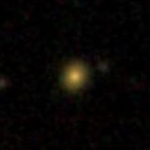

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361299980418.jpeg', 0.4991944636821747)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361299980432.jpeg', 0.4998507406234741)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361299980435.jpeg', 0.50043233294487)


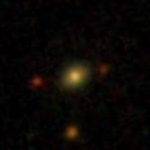

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361299980451.jpeg', 0.4987633134841919)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361300045945.jpeg', 0.5001425053596497)


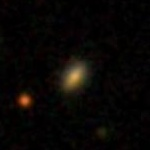

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361300045976.jpeg', 0.4979531969547272)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361300111377.jpeg', 0.49654312987327576)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361300176984.jpeg', 0.4975573923110962)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361300504666.jpeg', 0.49912117977142334)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361300570121.jpeg', 0.4970291163444519)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361300570192.jpeg', 0.49665000100135803)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361300832399.jpeg', 0.49385391731262207)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361300832490.jpeg', 0.5001774038791656)


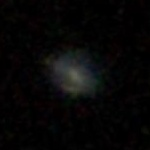

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361300963412.jpeg', 0.49884234924316406)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361301028929.jpeg', 0.5002983119010925)


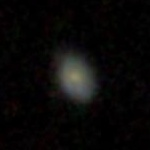

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361301029000.jpeg', 0.4986308123588562)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361301160007.jpeg', 0.501866271686554)


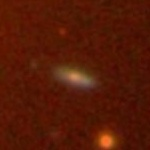

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361301160025.jpeg', 0.5000948216438293)


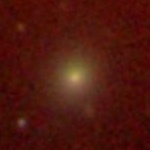

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361301291178.jpeg', 0.49632515568733215)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361301291232.jpeg', 0.49661584753990173)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361301356670.jpeg', 0.4971181954860687)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361301422229.jpeg', 0.4945623185157776)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361301618721.jpeg', 0.5000769998550415)


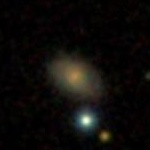

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361301618751.jpeg', 0.49815910120010376)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361301684348.jpeg', 0.49799030084609985)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361301749894.jpeg', 0.5005738045692444)


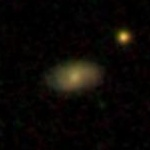

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361302077583.jpeg', 0.4984655882835388)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361302208617.jpeg', 0.4948635901927948)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361302470767.jpeg', 0.5001661684036255)


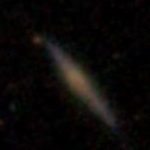

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361302470778.jpeg', 0.49835096855163574)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361302536315.jpeg', 0.498234143447876)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361302536442.jpeg', 0.49684463996887207)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361302667417.jpeg', 0.49980317611694336)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361302732914.jpeg', 0.4988187160015106)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361302929565.jpeg', 0.4973807539463043)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361302995031.jpeg', 0.5003345813274384)


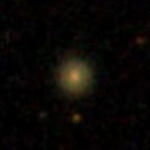

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361303126135.jpeg', 0.49564458985328674)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361303126156.jpeg', 0.4969509150505066)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361303191671.jpeg', 0.5000107194900513)


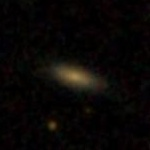

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361303191726.jpeg', 0.502089044046402)


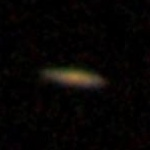

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361303453810.jpeg', 0.4981780852794647)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361303584949.jpeg', 0.4996536876678467)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361303650360.jpeg', 0.49695467014312744)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361303650603.jpeg', 0.500074883890152)


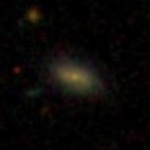

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361303912648.jpeg', 0.49865203161239624)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361303978108.jpeg', 0.4979589786052704)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361303978129.jpeg', 0.5000735129833221)


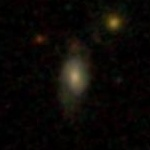

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361304240160.jpeg', 0.5004540588378906)


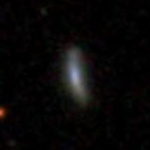

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361304240186.jpeg', 0.4942292775630951)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361304240332.jpeg', 0.5002662744045258)


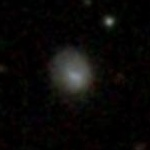

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361304502433.jpeg', 0.498694291305542)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361304895633.jpeg', 0.4953249897480011)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361304961154.jpeg', 0.4993375148296356)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361304961166.jpeg', 0.499900927734375)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361305026812.jpeg', 0.5000041033744812)


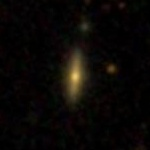

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361305026843.jpeg', 0.4989890958786011)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361305092226.jpeg', 0.5002367999076843)


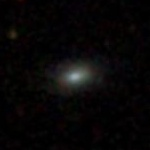

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361305419937.jpeg', 0.4998740758419037)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361305419967.jpeg', 0.49840809960365295)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361305551005.jpeg', 0.4975823666572571)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361305551039.jpeg', 0.5019455756664276)


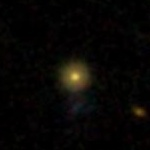

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361305682126.jpeg', 0.4986818935394287)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361305813118.jpeg', 0.49908070821762085)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361305813159.jpeg', 0.4995877947330475)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361305813178.jpeg', 0.5006979312419891)


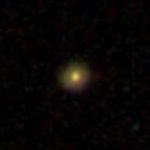

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361305878737.jpeg', 0.49838124771118164)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361305878756.jpeg', 0.49909543056488037)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361306009621.jpeg', 0.49857964177131653)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361306337363.jpeg', 0.4946274365901947)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361306337399.jpeg', 0.5010620858192444)


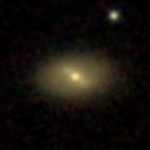

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361306402863.jpeg', 0.4930444266319275)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361306468444.jpeg', 0.49842556376457214)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361833181272.jpeg', 0.4993216003894806)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361833181279.jpeg', 0.49743418951034546)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361833181292.jpeg', 0.4982280637741089)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361833246757.jpeg', 0.49873971004486084)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361833246784.jpeg', 0.4974362160682678)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361833246814.jpeg', 0.49998607296943665)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Su

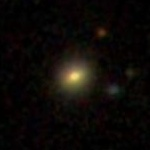

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361833574522.jpeg', 0.49749310870170593)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361833574526.jpeg', 0.4931613709449768)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361833640066.jpeg', 0.49535613317489624)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361833771112.jpeg', 0.5001348759651184)


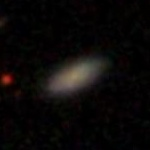

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361833771129.jpeg', 0.4981395806789398)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361833771137.jpeg', 0.4974481966018677)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361833836615.jpeg', 0.49867205877304077)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361833902240.jpeg', 0.4988749827861786)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361834164355.jpeg', 0.5005242135047913)


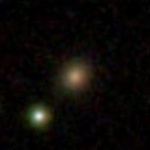

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361834229887.jpeg', 0.49649225730895996)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361834295404.jpeg', 0.4982496108531952)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361834295416.jpeg', 0.4991423096179962)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361834295437.jpeg', 0.49746154804229736)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361834360980.jpeg', 0.4980891849517822)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361834361001.jpeg', 0.4974163677215576)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361834361007.jpeg', 0.5008604433059692)


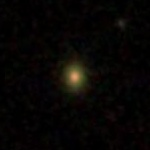

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361834361028.jpeg', 0.4948155786514282)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361834492031.jpeg', 0.49814899821281433)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361834623116.jpeg', 0.49947183389663696)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361834623134.jpeg', 0.4991001393318176)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361834688562.jpeg', 0.49506863017082214)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361834754355.jpeg', 0.49512960572242737)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361834819654.jpeg', 0.4954434241771698)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361835016288.jpeg', 0.4961732234477997)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Su

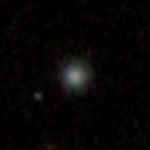

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361835278446.jpeg', 0.49089350361824036)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361835278534.jpeg', 0.49881624240875244)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361835737203.jpeg', 0.49568425674438477)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361835802729.jpeg', 0.4968438055038452)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361835933850.jpeg', 0.4954335298061371)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361835933867.jpeg', 0.49846013445854187)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361835933869.jpeg', 0.49956609864234924)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361835999345.jpeg', 0.49921922941207886)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/

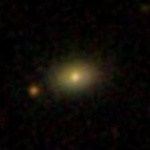

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361837703298.jpeg', 0.4997476245880127)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361837768833.jpeg', 0.4971521403312683)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361837834442.jpeg', 0.4896588232040405)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361838161999.jpeg', 0.4963734652519226)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361838358585.jpeg', 0.4947766568183899)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361838424208.jpeg', 0.49957477111816406)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361838424237.jpeg', 0.49344556589126587)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361838424402.jpeg', 0.49852799434661865)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Sub

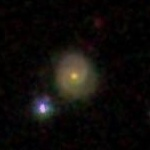

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361838489694.jpeg', 0.4994102026939392)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361838555255.jpeg', 0.49744941849708557)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361839079564.jpeg', 0.4967573489665985)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361839145119.jpeg', 0.4974115695476532)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361839210737.jpeg', 0.4940241183757782)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361839341699.jpeg', 0.5021851863384247)


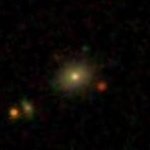

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361839538338.jpeg', 0.4988645817756653)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361839603855.jpeg', 0.4992865230560303)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361839603881.jpeg', 0.5010201241493225)


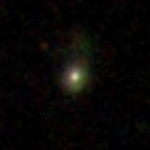

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361839603923.jpeg', 0.4982474650859833)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361839603933.jpeg', 0.4995805229663849)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361839800390.jpeg', 0.5012358035564423)


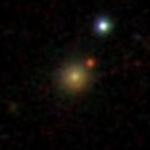

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361839931596.jpeg', 0.5013852324008942)


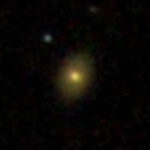

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361839931601.jpeg', 0.4991176034927368)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361839931614.jpeg', 0.49978603978157043)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361839931623.jpeg', 0.4997481610298157)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361839931629.jpeg', 0.49833395142555237)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361839931634.jpeg', 0.5009938086986542)


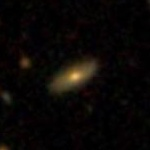

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361839997045.jpeg', 0.49775566716194153)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361839997060.jpeg', 0.4971676077365875)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361840062670.jpeg', 0.49924003143310547)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361840193622.jpeg', 0.498149355840683)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361840259139.jpeg', 0.49861787815093994)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361840390313.jpeg', 0.49877791662216187)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361840455850.jpeg', 0.49809779782295227)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361840521440.jpeg', 0.5003421511173248)


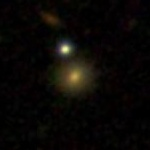

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361841045560.jpeg', 0.49630262513160706)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361841111198.jpeg', 0.49396829862594605)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361841176778.jpeg', 0.5009153391838074)


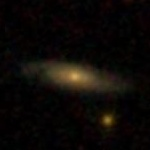

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361841307829.jpeg', 0.5009347106933594)


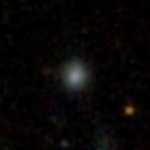

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361841373294.jpeg', 0.49614273567199707)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361841373413.jpeg', 0.5013911034584045)


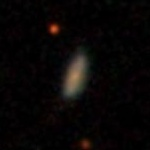

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361841438852.jpeg', 0.5010966565132141)


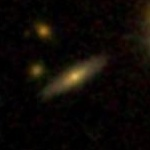

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361841504454.jpeg', 0.49557914395332336)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361841569870.jpeg', 0.49815674681663513)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361841832118.jpeg', 0.5015906300067902)


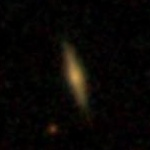

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361841897688.jpeg', 0.4997664596557617)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361841963124.jpeg', 0.5011055376052856)


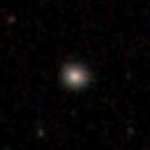

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361841963266.jpeg', 0.49810533781051636)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361842225234.jpeg', 0.4963271822452545)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361842356554.jpeg', 0.49592410583496094)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361842421966.jpeg', 0.5005909111022949)


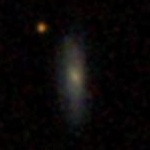

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361842553022.jpeg', 0.501152535867691)


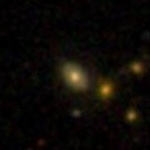

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361842553044.jpeg', 0.5000816192150116)


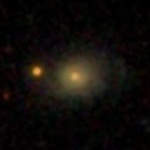

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361842618579.jpeg', 0.49492596645355225)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361842815095.jpeg', 0.5006165709018707)


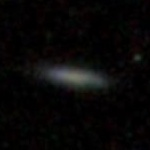

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361842880594.jpeg', 0.4989641215324402)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361843142791.jpeg', 0.4967699255466461)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361843208408.jpeg', 0.49738865156173706)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361843339333.jpeg', 0.5001472141265869)


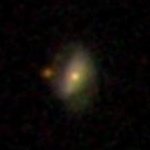

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361843339457.jpeg', 0.4980805720806122)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361843470531.jpeg', 0.4991799201488495)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361843535987.jpeg', 0.49507491846084595)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361843601653.jpeg', 0.5006282236099243)


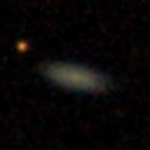

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361843601693.jpeg', 0.4934406485080719)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361843732679.jpeg', 0.4982924963951111)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361843732750.jpeg', 0.5007432605743408)


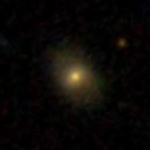

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361843798146.jpeg', 0.500613590669632)


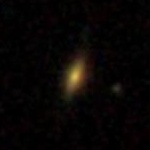

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361843798159.jpeg', 0.498159041595459)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361843863766.jpeg', 0.4962996747016907)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361843863777.jpeg', 0.49914758462905884)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361843863881.jpeg', 0.49728869457244873)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361843929192.jpeg', 0.4973916615962982)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361843929204.jpeg', 0.49828915853500366)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361844060408.jpeg', 0.49770157594680786)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361844125839.jpeg', 0.4988979901790619)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Sub

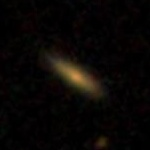

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361844191426.jpeg', 0.5016154255390167)


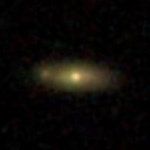

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361844256780.jpeg', 0.4944966341972351)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361844256921.jpeg', 0.49802376885414124)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361844584619.jpeg', 0.5008122827529907)


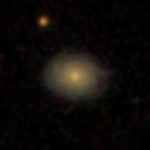

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661361844584655.jpeg', 0.5004042293548584)


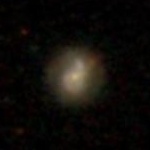

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661362367496228.jpeg', 0.4947402979850769)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661362367496292.jpeg', 0.49907510538101196)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661362367561845.jpeg', 0.49267472882270813)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661362367692844.jpeg', 0.4933934714317322)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661362367692918.jpeg', 0.49703001041412354)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661362367692921.jpeg', 0.4945848192691803)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661362367758400.jpeg', 0.49368058700561523)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661362367758447.jpeg', 0.494638761472702)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Sub

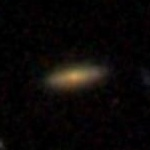

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661353778806829.jpeg', 0.49890070219039917)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661353778806968.jpeg', 0.49809472818374634)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661353778806979.jpeg', 0.49907272119522095)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661353778872400.jpeg', 0.4949749614715576)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661353778872411.jpeg', 0.4952069725513458)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661353779069038.jpeg', 0.49831174869537354)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661353779134608.jpeg', 0.4956972505569458)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661353779200085.jpeg', 0.4968723561286926)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Su

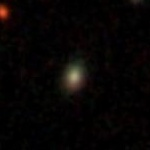

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661353779855436.jpeg', 0.49682914276123047)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661353779855454.jpeg', 0.4972458686351776)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661353779986729.jpeg', 0.49929987449645996)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661353780052019.jpeg', 0.4951136018753052)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661353780052021.jpeg', 0.4938066210269928)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661353780183147.jpeg', 0.4948885943412781)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661353780248655.jpeg', 0.4987659062862396)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661353780248665.jpeg', 0.4930383767604828)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subf

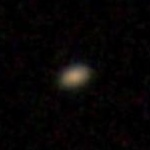

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661353780707408.jpeg', 0.49864842553138733)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661353780707411.jpeg', 0.49832337160110474)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661353780707425.jpeg', 0.49856545586586)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661353780838517.jpeg', 0.49692242403030396)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661353780838569.jpeg', 0.49763526577949524)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661353781035203.jpeg', 0.49922244806289673)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661354314694811.jpeg', 0.4976961817264557)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661354314694814.jpeg', 0.49859850664138794)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Su

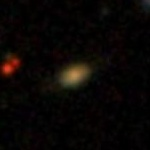

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661354315153526.jpeg', 0.49818213839530945)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661354315153557.jpeg', 0.4956509377479553)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661354315219108.jpeg', 0.4992768074989319)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661354315219111.jpeg', 0.497622331571579)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661354315284553.jpeg', 0.49872972626686096)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661354315415604.jpeg', 0.49787797589302063)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661354315415612.jpeg', 0.4932587649345398)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661354315415668.jpeg', 0.502275070142746)


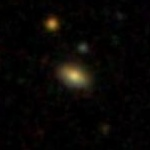

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661354315415685.jpeg', 0.49862124581336975)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661354315481175.jpeg', 0.4980253185749054)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661354315546849.jpeg', 0.49958284754753113)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661354315612170.jpeg', 0.4961305465221405)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661354315612368.jpeg', 0.4984510447502136)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661354315677884.jpeg', 0.5001284088611603)


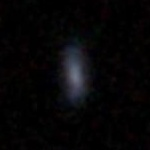

('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661354315677904.jpeg', 0.4948473479270935)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661354315677922.jpeg', 0.4993414487361908)
('/content/drive/MyDrive/Degree/Jobs/SIGP/galaxies/317018/Subfolder_8/1237661354315743326.jpeg', 0.4959101285457611)


In [26]:
norm = 0.1502

dict_galaxies = {}
file_paths = get_paths(image_path)

from IPython.display import Image, display
for i in range(len(flattened_numpy_arrays)):
  if flattened_numpy_arrays[i] != None:
    print((file_paths[i], flattened_numpy_arrays[i][0] + norm))

    if flattened_numpy_arrays[i][0] + norm > 0.5:
      dict_galaxies[file_paths[i]] = flattened_numpy_arrays[i][0] + norm
      display(Image(filename=file_paths[i]))
  else:
    print((i, None))

In [27]:
import json
data = dict_galaxies
# Specify the file path where you want to save the JSON data
file_path = image_path.split("/")[-1] + ".json"
# Write the dictionary to the JSON file
with open(file_path, "w") as json_file:
    json.dump(data, json_file)